# SEC Filings

The data is provided in zipped text files. Unzip the file and place the 'SEC-filings' directory into the './data' directory. 

A related dataset in similar format is the conll2003 dataset, available from [HuggingFace](https://huggingface.co/datasets/conll2003). This could be used as a source of additional training data, but note it contains a different kind of text (different 'domain'). 

In [2]:
%load_ext autoreload
%autoreload 2

# Data Extraction
import sys
sys.path.append('..')

import data_loader
import warnings
import functions as f
import params as p
import eli5
import seaborn as sns

# Other
import matplotlib.pyplot as plt
import nltk
from sklearn.exceptions import UndefinedMetricWarning
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import optuna

/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Settings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action = 'ignore', category = UndefinedMetricWarning)

## Import Data

In [4]:
(
    train_sentences_ner, train_labels_ner, test_sentences_ner, test_labels_ner, val_sentences_ner, val_labels_ner,
    ) = data_loader.import_task2_data()

Loading the original training set: 
Number of sentences loaded = 1152
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']

Loading the test set: 
Number of sentences loaded = 303
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']


# Task 2 Answer

### Clean Data

In [5]:
def crf_word_preprocessing(word, ref):

    word_features = {
        'bias' : 1.0,
        f'word_{ref}_lower' : word.lower(),
        f'word_{ref}_end3' : word[-3:],
        f'word_{ref}_end2' : word[-2:],
        f'word_{ref}_beg' : word[:3],
        f'word_{ref}_isupper' : word.isupper(),
        f'word_{ref}_istitle' : word.istitle(),
        f'word_{ref}_isdigit' : word.isdigit(),
        f'word_{ref}_postag' : nltk.pos_tag([word])[0][1]
        }

    return word_features

In [6]:
def crf_sentence_preprocessing(sentence):

    sentence_features = []

    for idx in range(len(sentence)):

        word = sentence[idx]

        word_features = crf_word_preprocessing(word, 0)

        if idx > 0:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx - 1], -1)
                }
        else:
            word_features['BOS'] = True

        if idx < len(sentence) - 1:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx + 1], +1)
            }
        else:
            word_features['EOS'] = True

        sentence_features.append(word_features)

    return sentence_features

In [7]:
def crf_data_preprocessing(data):
    opt = [crf_sentence_preprocessing(sentence) for sentence in data]
    print('data:', len(data), 'out:', len(opt))
    return opt

### Preprocess Data

In [8]:
X_train = crf_data_preprocessing(train_sentences_ner)
X_test = crf_data_preprocessing(test_sentences_ner)
X_val = crf_data_preprocessing(val_sentences_ner)

data: 864 out: 864
data: 303 out: 303
data: 288 out: 288


### NER Modelling

In [9]:
tagger = CRF()
tagger.fit(
    X = X_train,
    y = train_labels_ner,
)

CRF(keep_tempfiles=None)

In [10]:
f.evaluate_model(
    tagger,
    X_train = X_train,
    X_val = X_val,
    y_train = train_labels_ner,
    y_val=val_labels_ner,)

,F1 Score,Accuracy,Precision,Recall
Train,0.973249,0.998070,0.996275,0.951807
Validation,0.908929,0.994802,0.956850,0.875000


In [11]:
y_pred = tagger.predict(X_val)

In [12]:
labels = list(tagger.classes_)
labels.remove('O')
labels

['I-PER', 'I-ORG', 'I-LOC', 'I-MISC']

In [13]:
print('F1 Score (train):', flat_f1_score(train_labels_ner, tagger.predict(X_train), average='weighted', labels=labels))
print('F1 Score (validation):', flat_f1_score(val_labels_ner, tagger.predict(X_val), average='weighted', labels=labels))

F1 Score (train): 0.9732491978487775
F1 Score (validation): 0.9089286487839587


### Improving Robustness of Model

In [14]:
tuned_crf = CRF(
    c1 = 1,
    c2 = 0.0001
)

tuned_crf.fit(X_train, train_labels_ner)

CRF(c1=1, c2=0.0001, keep_tempfiles=None)

In [15]:
eval_results = f.evaluate_model(
    tuned_crf,
    X_train = X_train,
    X_val = X_val,
    y_train = train_labels_ner,
    y_val = val_labels_ner,
    X_test = X_test,
    y_test = test_labels_ner)

eval_results

,F1 Score,Accuracy,Precision,Recall
Train,0.912832,0.994209,0.974026,0.863167
Validation,0.904823,0.994711,0.949426,0.869565
Test,0.705176,0.986564,0.882777,0.619266


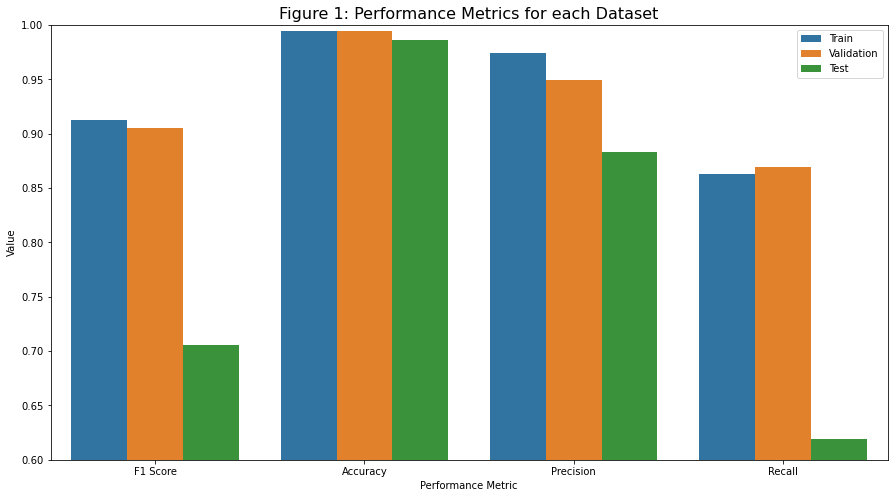

In [16]:
melt_data = eval_results.reset_index().melt(id_vars = 'index')

fig, ax = plt.subplots(1,1,figsize=(15, 8))

sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'variable',
    y = 'value',
    hue = 'index'
).set(label = 'Datasets')

plt.legend(loc = 'upper right')
plt.xlabel('Performance Metric')
plt.ylabel('Value')
plt.ylim(0.6, 1)
plt.title('Figure 1: Performance Metrics for each Dataset', fontsize = 16)
plt.savefig('./final_metrics.png')
plt.show()

### Displaying Results

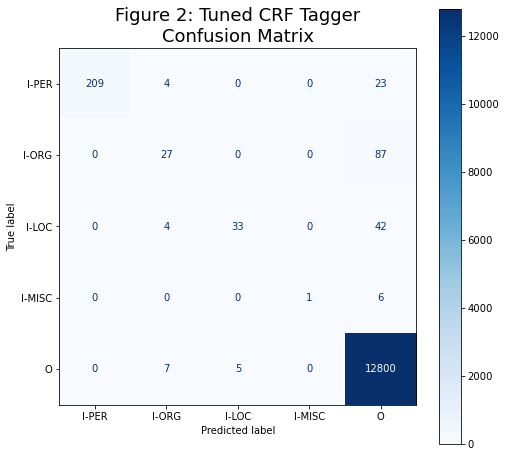

In [17]:
def create_confusion_matrix(y_true, y_pred, ner_labels):

    ner_labels.append('O')

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    true = [label for sent_list in y_true for label in sent_list]
    pred = [label for sent_list in y_pred for label in sent_list]

    cm = confusion_matrix(true, pred, ner_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ner_labels)
    disp.plot(cmap = 'Blues', ax = ax)

    plt.title('Figure 2: Tuned CRF Tagger\nConfusion Matrix', fontdict={'fontsize' : 18})

    plt.savefig('./crf_confusion_matrix.png')

    plt.show()

create_confusion_matrix(
    y_pred = tuned_crf.predict(X_test),
    y_true = test_labels_ner,
    ner_labels = labels
)

In [18]:
print(flat_classification_report(
    y_true=test_labels_ner,
    y_pred=tuned_crf.predict(X_test),
    labels = labels
))

              precision    recall  f1-score   support

       I-PER       1.00      0.89      0.94       236
       I-ORG       0.64      0.24      0.35       114
       I-LOC       0.87      0.42      0.56        79
      I-MISC       1.00      0.14      0.25         7
           O       0.99      1.00      0.99     12812

    accuracy                           0.99     13248
   macro avg       0.90      0.54      0.62     13248
weighted avg       0.98      0.99      0.98     13248



### Eli5

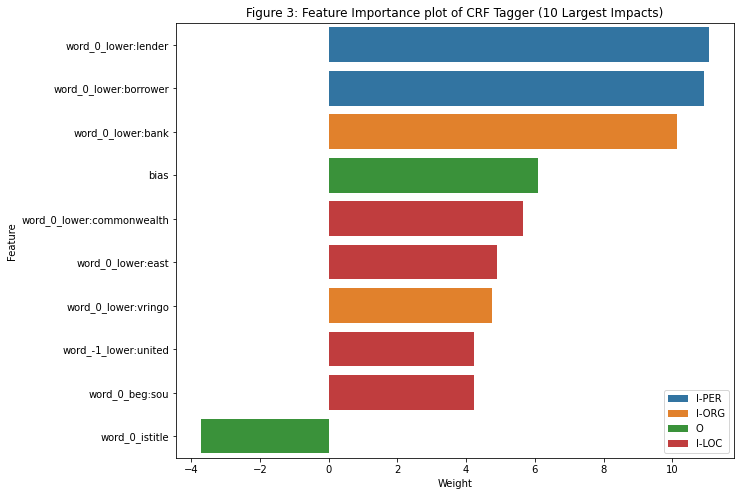

In [45]:
test = eli5.formatters.explain_weights_dfs(tuned_crf)['targets']
test['weight_sort'] = abs(test['weight'])
test = test.nlargest(10, columns = 'weight_sort')

fig, ax = plt.subplots(1,1, figsize = (10, 8))

sns.barplot(
    ax = ax,
    data = test,
    y = 'feature',
    x = 'weight',
    hue = 'target',
    dodge=False
)
plt.legend(loc = 'lower right')
plt.title('Figure 3: Feature Importance plot of CRF Tagger (10 Largest Impacts)')
plt.ylabel('Feature')
plt.xlabel('Weight')
plt.show()

## Financial Phrasebank

In [46]:
(train_sentences_fp, test_sentences_fp, val_sentences_fp, train_labels_fp, test_labels_fp, val_labels_fp,
    ) = data_loader.import_task1_data()

sentences_fp = train_sentences_fp + test_sentences_fp + val_sentences_fp
labels_fp = train_labels_fp + test_labels_fp + val_labels_fp

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 41.28it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})
How many instances in the train dataset? 

3876

What does one instance look like? 

a January 11 , 2010 EPHC board of directors has approved an increase in the quarterly dividend from $ 0.03 to $ 0.05 per share .
instances in the validation dataset 

969

instances in the test dataset 

970


### Process Data

In [47]:
def vectorise_data(lst):

    return [nltk.word_tokenize(sentence) for sentence in lst]

In [48]:
sentences_fp = vectorise_data(sentences_fp)

In [49]:
labels_sent_scores = list(map(lambda x: {0: -1, 1: 0, 2: 1}[x], labels_fp))

In [50]:
sentences_fp_pp = crf_data_preprocessing(sentences_fp)

data: 4846 out: 4846


In [51]:
fp_preds = tuned_crf.predict(sentences_fp_pp)

In [69]:
fp_preds_and_scores = []

for sentence, labels, sentiment in zip(sentences_fp, fp_preds, labels_sent_scores):

    for word, label in zip(sentence, labels):

        if label != 'O':
            fp_preds_and_scores.append((word, label, sentiment))

scores = {}

for word, lab, sent in fp_preds_and_scores:
    if lab == 'I-ORG':
        if word in scores.keys():
            scores[word] += sent
        else:
            scores[word] = sent

scores

{'Bank': 14,
 'Group': 3,
 'Nordea': 4,
 'Sampo': 2,
 'YIT': 3,
 'Corporation': 25,
 'Hamina': 0,
 'Terminal': 0,
 'Services': 1,
 'Ltd': 0,
 'and': 2,
 'Kaukomarkkinat': 0,
 'Ltd.': 0,
 'Finnish': 6,
 'Ahlstrom': 2,
 'Kaleva': 0,
 'Kustannus': 0,
 'Oy': 0,
 'Rapala': -2,
 'VMC': -2,
 'National': 2,
 'Fund': 0,
 'Componenta': 0,
 'HKScan': 0,
 'John': 0,
 'F': 0,
 'Kennedy': 0,
 'Stewart': 0,
 'International': 2,
 'Nokia': 2,
 'Corp.': 2,
 'Goldman': -1,
 'Sachs': -1,
 "'": -1,
 'Whitehall': 0,
 'Street': 0,
 'Real': 0,
 'Estate': 0,
 'Funds': 0,
 'U.S.': 2,
 'Securities': 0,
 'Exchange': 0,
 'Commission': 0,
 'Neste': 0,
 'Oil': 0,
 'of': 3,
 'Glaston': 0,
 'Technologies': -1,
 'Big': 1,
 'Bear': 1,
 'Erdenet': 1,
 'Mining': 1,
 'Pohjola': 2,
 'Italy': 0,
 'Global': 1,
 'Research': 0,
 'Pohjoa': 0,
 'M.': 0,
 'Danske': 2,
 'bank': 3,
 'financial': 1,
 'solutions': 2,
 'developer': 2,
 'Basware': 3,
 'London': -1,
 'Monday': -1,
 'Economic': 0,
 'Affairs': 0,
 'Minister': 0,
 'Trojan':

In [52]:
labels = tuned_crf.classes_
labels

['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC']